In [1]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [3]:
time_window = 50
time_step = 25
n_splits = 1000
trial_averages = [0,20]
group_dict = {0:[1],1:[2],2:[3],3:[4]}
test = False # if true, test pipeline on only 3 subjects
experiment_names = ['1801','1901','1902']

# loop over all 3 experiments
for experiment_name in experiment_names:
    print(f'Experiment: {experiment_name}\n')
    # loop over single trial and binned trials
    for trial_average in trial_averages:
        print(f'Trial Bin: {trial_average}\n')

        # create experiment, data wrangler, and classification objects
        data_dir = f'./data/{experiment_name}'
        exp = decode_eeg.Experiment(experiment_name,data_dir,test=test)
        wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)
        clfr = decode_eeg.Classification(wrangl,exp.nsub)

        # loop over subjects in experiment
        for isub in range(exp.nsub):
            print(isub)

            # load and format data
            xdata,ydata = exp.load_eeg(isub)
            xdata,ydata = wrangl.setup_data(xdata,ydata)
            
            # split data into train and test
            for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
                y_test_shuffle = np.random.permutation(y_test)
                # roll over trial timecourse
                for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    # do classification
                    clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

        # create classification interpreter object
        interp = decode_eeg.Interpreter(clfr, subtitle = f'{experiment_name}_trialbin{str(trial_average)}_')
        interp.save_results()

        # plot classification results
        interp.plot_acc(significance_testing=True,savefig=0)
        # interp.plot_conf_mat(upper=.5,lower=0, savefig=0)

Experiment: 1801

Trial Bin: 0

0
1
2
3
4
5
6
7


KeyboardInterrupt: 

# Classification stability over time 

In [37]:
experiment_name1 = '1801'
experiment_name2 = '1901'
experiment_name3 = '1902'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'
data_dir3 = f'./data/{experiment_name3}'

exp1 = decode_eeg.Experiment(experiment_name1,data_dir1)
exp2 = decode_eeg.Experiment(experiment_name2,data_dir2)
exp3 = decode_eeg.Experiment(experiment_name3,data_dir3)

wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits)

sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2,exp3],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2])

In [31]:
filenames = ['1801_trialbin20_20200529_2024.pickle','1901_trialbin20_20200530_0232.pickle','1902_trialbin20_20200530_0422.pickle']
accs = np.empty((3),dtype='object')
for iexp,exp in enumerate(zip(sync.experiments,filenames)):
    
    clfr = decode_eeg.Classification(wrangl,exp[0].nsub,num_labels = 4)
    clfr.wrangl.labels = [0,1,2,3]
    interp = decode_eeg.Interpreter(clfr)
    interp.load_results(exp[1])
    accs[iexp] = interp.acc

In [65]:
acc_sync = np.empty((3,20))
for isub,id in enumerate(sync.id_dict.keys()):
    for iexp,exp in enumerate(sync.experiment_names):
        acc =  accs[iexp][sync.id_dict[id][exp]]
        acc_sync[iexp,isub] = np.mean(acc[clfr.t>250])

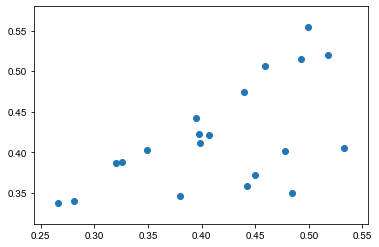

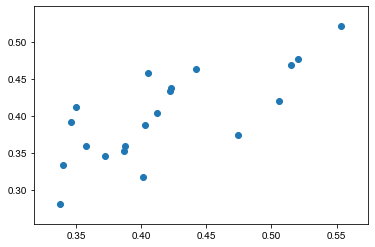

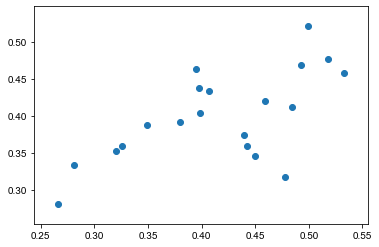

In [72]:
plt.scatter(acc_sync[0],acc_sync[1])
plt.show()
plt.scatter(acc_sync[1],acc_sync[2])
plt.show()
plt.scatter(acc_sync[0],acc_sync[2])

In [191]:
from scipy.stats import linregress
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def plot_corr(x,y):
    r_value = np.empty((len(x)))
    p_value = np.empty((len(x)))
    ax = plt.subplot(111)
    for i,xy in enumerate(zip(x,y)):
        slope, intercept, r_value[i], p_value[i], std_err = linregress(xy[0], xy[1])

        ax.scatter(xy[0],xy[1])
        abline(slope,intercept)

        plt.plot()
        plt.xlim(.25,.6)
        plt.ylim(.25,.6)
    r = round(np.mean(r_value)**2,2)
    p = np.mean(p_value)
    plt.text(.59,.6,f'R-squared = {r}\np-value = {str(p)[0:4]}',verticalalignment='top',horizontalalignment='right',)
    plt.legend(['Color-Ori','Color-Conj','Ori-Conj'],loc='best')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks(np.arange(.2,.61,.1))
    ax.xaxis.set_ticks(np.arange(.3,.61,.1))

    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)

    # labelling
    plt.xlabel('Decoding accuracy', fontsize=14)
    plt.ylabel('Decoding accuracy', fontsize=14)

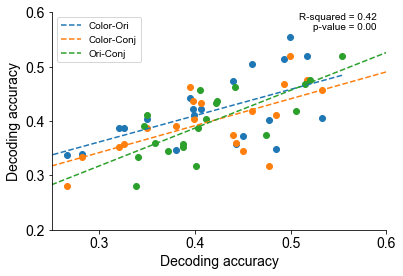

In [194]:
plot_corr(x=[data[0],data[0],data[1]],y = [data[1],data[2],data[2]])
plt.savefig('sub_acc.pdf')
plt.savefig('sub_acc.png',dpi=1000)